In [1]:
#!pip install -r requirements.txt

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
import sys
print(sys.executable)
sys.path.append('/Users/janbannister/miniconda3/envs/jan_micrograd/lib/python3.12/site-packages')
from graphviz import Digraph

/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10


In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            #print("\t + : Backward: 1.0 + " + str(self.grad) + " = " + str(self.grad))
            #print("\t + : Backward: 1.0 + " + str(self.grad) + " = " + str(other.grad))
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            #print("\t * : Backward: * -> " + str(self.grad))
            #print("\t * : Backward: * -> " + str(other.grad))
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            #print("x =        :",x)
            #print("t =        :",t)
            #print("out.grad = :")
            #print("\t tanh    : Backward: tanh(x) : " + str(1 - t**2) +  " * " + str(out.grad))
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            #print(node)
            node._backward()
            
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
        
    def __repr__(self):
        return f"{self.label} \t= Value(op={self._op}, data={self.data}, grad={self.grad})"

In [5]:
xxx = Value(2,label='xxx')
yyy = Value(2,label='yyy')
zzz = xxx / yyy; zzz.label = 'zzz'
zzz


zzz 	= Value(op=*, data=1.0, grad=0.0)

In [6]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
        
    def build(v):
        if v not in nodes: 
            nodes.add(v) 
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root) 
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it 
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [7]:
# inputs xl,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')
# bias of the neuron
b = Value(6.88137358, label='b')
# x1*wl + x2*w2 + b
x1w1 = x1*w1; x1w1.label = '×1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
x1w1x2w2.data = -6.0

n = x1w1x2w2 + b;n.label = 'n'
o = n.tanh(); o.label = 'o'

o.data = 0.7071
n.data = 0.8814

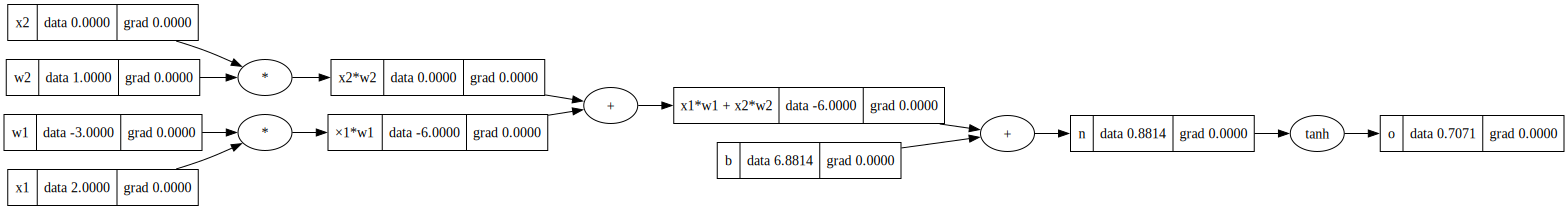

In [8]:
draw_dot(o)

In [9]:
o.backward()

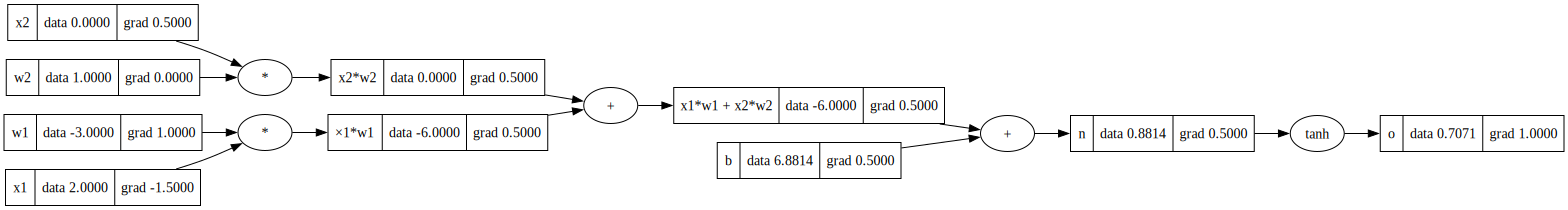

In [10]:
draw_dot(o)

In [22]:
class Neuron():

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1), label='w') for _ in range(nin)]
        self.b = Value(0)
        
    def __call__(self, x):
        #w dot product x + b
        #print(list(zip(self.w,x)))
        #zip(self.w,x)
        #for wi,xi in zip(self.w, x):
        #    print("row: ",wi,xi)
        
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        #print(act)
        out = act.tanh() 
        return act
    
class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
class MLP():

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
x =[2.0, 3.0, -3.0]
n = MLP(2, [4,4,1])
n(x)

 	= Value(op=+, data=-1.2856858912176143, grad=0.0)

In [25]:
#draw_dot(n(x))

In [24]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0,  1.0],
      [1.0, 1.0, -1.0],
     ]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[ 	= Value(op=+, data=-1.2856858912176143, grad=0.0),
  	= Value(op=+, data=-0.7562335694527136, grad=0.0),
  	= Value(op=+, data=-0.37470762132139024, grad=0.0),
  	= Value(op=+, data=-0.5362706485748333, grad=0.0)]